### Connect to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from tensorflow.keras import datasets, models, layers

### Load data

In [3]:
X_train = np.load('/content/drive/MyDrive/data for 2 custom/X_train.npy')
X_test = np.load('/content/drive/MyDrive/data for 2 custom/X_test.npy')
Y_train = np.load('/content/drive/MyDrive/data for 2 custom/Y_train.npy')
Y_test = np.load('/content/drive/MyDrive/data for 2 custom/Y_test.npy')
label = np.load('/content/drive/MyDrive/data for 2 custom/label.npy')

### Check if have any missing data

In [4]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((74262, 32, 32), (21309, 32, 32), (74262, 2), (21309, 2))

In [5]:
X_train[0]

array([[0.03921569, 0.03921569, 0.03921569, ..., 0.01960784, 0.01960784,
        0.01960784],
       [0.03921569, 0.03921569, 0.03921569, ..., 0.01960784, 0.01960784,
        0.01960784],
       [0.03921569, 0.03921569, 0.03921569, ..., 0.01960784, 0.01960784,
        0.01960784],
       ...,
       [0.00784314, 0.00784314, 0.00784314, ..., 0.42352942, 0.42352942,
        0.42352942],
       [0.00784314, 0.00784314, 0.00784314, ..., 0.42352942, 0.42352942,
        0.42352942],
       [0.00784314, 0.00784314, 0.00784314, ..., 0.42352942, 0.42352942,
        0.42352942]], dtype=float32)

In [6]:
Y_train[0]

array([0., 1.])

### Model and Train

In [7]:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)

In [8]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
aug.fit(X_train)

In [9]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [10]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [11]:
model = ResNet18(2)
model.build(input_shape = (None, 32, 32, 1))
#use categorical_crossentropy since the label is one-hot encoded
from keras.optimizers import SGD
# opt = SGD(learning_rate=0.1,momentum=0.9,decay = 1e-04) #parameters suggested by He [1]
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy", f1_m, precision_m, recall_m])
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  3200      
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 resnet_block (ResnetBlock)  multiple                  74368     
                                                                 
 resnet_block_1 (ResnetBloc  multiple               

In [12]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience= 8, restore_best_weights=True)
#I did not use cross validation, so the validate performance is not accurate.
STEPS = len(X_train) / 256
history = model.fit(aug.flow(X_train,Y_train,batch_size = 256), steps_per_epoch=STEPS, batch_size = 256, epochs= 50, callbacks=[es])

Epoch 1/50
291/290 [==============================] - ETA: 0s - loss: 0.5701 - accuracy: 0.7209 - f1_m: 0.7207 - precision_m: 0.7207 - recall_m: 0.7207

290/290 [==============================] - 51s 90ms/step - loss: 0.5701 - accuracy: 0.7209 - f1_m: 0.7207 - precision_m: 0.7207 - recall_m: 0.7207
Epoch 2/50
291/290 [==============================] - ETA: 0s - loss: 0.3539 - accuracy: 0.8402 - f1_m: 0.8400 - precision_m: 0.8400 - recall_m: 0.8400

290/290 [==============================] - 27s 93ms/step - loss: 0.3539 - accuracy: 0.8402 - f1_m: 0.8400 - precision_m: 0.8400 - recall_m: 0.8400
Epoch 3/50
291/290 [==============================] - ETA: 0s - loss: 0.3025 - accuracy: 0.8673 - f1_m: 0.8670 - precision_m: 0.8670 - recall_m: 0.8670

290/290 [==============================] - 25s 88ms/step - loss: 0.3025 - accuracy: 0.8673 - f1_m: 0.8670 - precision_m: 0.8670 - recall_m: 0.8670
Epoch 4/50
291/290 [==============================] - ETA: 0s - loss: 0.2708 - accuracy: 0.8829 - f1_m: 0.8825 - precision_m: 0.8825 - recall_m: 0.8825

290/290 [==============================] - 26s 90ms/step - loss: 0.2708 - accuracy: 0.8829 - f1_m: 0.8825 - precision_m: 0.8825 - recall_m: 0.8825
Epoch 5/50
291/290 [==============================] - ETA: 0s - loss: 0.2559 - accuracy: 0.8897 - f1_m: 0.8896 - precision_m: 0.8896 - recall_m: 0.8896

290/290 [==============================] - 26s 88ms/step - loss: 0.2559 - accuracy: 0.8897 - f1_m: 0.8896 - precision_m: 0.8896 - recall_m: 0.8896
Epoch 6/50
291/290 [==============================] - ETA: 0s - loss: 0.2354 - accuracy: 0.8988 - f1_m: 0.8988 - precision_m: 0.8988 - recall_m: 0.8988

290/290 [==============================] - 25s 87ms/step - loss: 0.2354 - accuracy: 0.8988 - f1_m: 0.8988 - precision_m: 0.8988 - recall_m: 0.8988
Epoch 7/50
291/290 [==============================] - ETA: 0s - loss: 0.2242 - accuracy: 0.9043 - f1_m: 0.9041 - precision_m: 0.9041 - recall_m: 0.9041

290/290 [==============================] - 25s 87ms/step - loss: 0.2242 - accuracy: 0.9043 - f1_m: 0.9041 - precision_m: 0.9041 - recall_m: 0.9041
Epoch 8/50
291/290 [==============================] - ETA: 0s - loss: 0.2128 - accuracy: 0.9102 - f1_m: 0.9102 - precision_m: 0.9102 - recall_m: 0.9102

290/290 [==============================] - 25s 87ms/step - loss: 0.2128 - accuracy: 0.9102 - f1_m: 0.9102 - precision_m: 0.9102 - recall_m: 0.9102
Epoch 9/50
291/290 [==============================] - ETA: 0s - loss: 0.2026 - accuracy: 0.9141 - f1_m: 0.9141 - precision_m: 0.9141 - recall_m: 0.9141

290/290 [==============================] - 25s 87ms/step - loss: 0.2026 - accuracy: 0.9141 - f1_m: 0.9141 - precision_m: 0.9141 - recall_m: 0.9141
Epoch 10/50
291/290 [==============================] - ETA: 0s - loss: 0.1946 - accuracy: 0.9186 - f1_m: 0.9185 - precision_m: 0.9185 - recall_m: 0.9185

290/290 [==============================] - 25s 87ms/step - loss: 0.1946 - accuracy: 0.9186 - f1_m: 0.9185 - precision_m: 0.9185 - recall_m: 0.9185
Epoch 11/50
291/290 [==============================] - ETA: 0s - loss: 0.1836 - accuracy: 0.9240 - f1_m: 0.9241 - precision_m: 0.9241 - recall_m: 0.9241

290/290 [==============================] - 25s 84ms/step - loss: 0.1836 - accuracy: 0.9240 - f1_m: 0.9241 - precision_m: 0.9241 - recall_m: 0.9241
Epoch 12/50
291/290 [==============================] - ETA: 0s - loss: 0.1785 - accuracy: 0.9266 - f1_m: 0.9265 - precision_m: 0.9265 - recall_m: 0.9265

290/290 [==============================] - 25s 87ms/step - loss: 0.1785 - accuracy: 0.9266 - f1_m: 0.9265 - precision_m: 0.9265 - recall_m: 0.9265
Epoch 13/50
291/290 [==============================] - ETA: 0s - loss: 0.1794 - accuracy: 0.9250 - f1_m: 0.9248 - precision_m: 0.9248 - recall_m: 0.9248

290/290 [==============================] - 25s 85ms/step - loss: 0.1794 - accuracy: 0.9250 - f1_m: 0.9248 - precision_m: 0.9248 - recall_m: 0.9248
Epoch 14/50
291/290 [==============================] - ETA: 0s - loss: 0.1622 - accuracy: 0.9331 - f1_m: 0.9331 - precision_m: 0.9331 - recall_m: 0.9331

290/290 [==============================] - 25s 87ms/step - loss: 0.1622 - accuracy: 0.9331 - f1_m: 0.9331 - precision_m: 0.9331 - recall_m: 0.9331
Epoch 15/50
291/290 [==============================] - ETA: 0s - loss: 0.1556 - accuracy: 0.9362 - f1_m: 0.9364 - precision_m: 0.9364 - recall_m: 0.9364

290/290 [==============================] - 25s 84ms/step - loss: 0.1556 - accuracy: 0.9362 - f1_m: 0.9364 - precision_m: 0.9364 - recall_m: 0.9364
Epoch 16/50
291/290 [==============================] - ETA: 0s - loss: 0.1569 - accuracy: 0.9363 - f1_m: 0.9361 - precision_m: 0.9361 - recall_m: 0.9361

290/290 [==============================] - 26s 88ms/step - loss: 0.1569 - accuracy: 0.9363 - f1_m: 0.9361 - precision_m: 0.9361 - recall_m: 0.9361
Epoch 17/50
291/290 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.9397 - f1_m: 0.9394 - precision_m: 0.9394 - recall_m: 0.9394

290/290 [==============================] - 24s 83ms/step - loss: 0.1478 - accuracy: 0.9397 - f1_m: 0.9394 - precision_m: 0.9394 - recall_m: 0.9394
Epoch 18/50
291/290 [==============================] - ETA: 0s - loss: 0.1452 - accuracy: 0.9408 - f1_m: 0.9406 - precision_m: 0.9406 - recall_m: 0.9406

290/290 [==============================] - 25s 86ms/step - loss: 0.1452 - accuracy: 0.9408 - f1_m: 0.9406 - precision_m: 0.9406 - recall_m: 0.9406
Epoch 19/50
291/290 [==============================] - ETA: 0s - loss: 0.1367 - accuracy: 0.9446 - f1_m: 0.9447 - precision_m: 0.9447 - recall_m: 0.9447

290/290 [==============================] - 26s 88ms/step - loss: 0.1367 - accuracy: 0.9446 - f1_m: 0.9447 - precision_m: 0.9447 - recall_m: 0.9447
Epoch 20/50
291/290 [==============================] - ETA: 0s - loss: 0.1299 - accuracy: 0.9476 - f1_m: 0.9478 - precision_m: 0.9478 - recall_m: 0.9478

290/290 [==============================] - 25s 87ms/step - loss: 0.1299 - accuracy: 0.9476 - f1_m: 0.9478 - precision_m: 0.9478 - recall_m: 0.9478
Epoch 21/50
291/290 [==============================] - ETA: 0s - loss: 0.1259 - accuracy: 0.9496 - f1_m: 0.9494 - precision_m: 0.9494 - recall_m: 0.9494

290/290 [==============================] - 25s 87ms/step - loss: 0.1259 - accuracy: 0.9496 - f1_m: 0.9494 - precision_m: 0.9494 - recall_m: 0.9494
Epoch 22/50
291/290 [==============================] - ETA: 0s - loss: 0.1250 - accuracy: 0.9500 - f1_m: 0.9500 - precision_m: 0.9500 - recall_m: 0.9500

290/290 [==============================] - 25s 87ms/step - loss: 0.1250 - accuracy: 0.9500 - f1_m: 0.9500 - precision_m: 0.9500 - recall_m: 0.9500
Epoch 23/50
291/290 [==============================] - ETA: 0s - loss: 0.1232 - accuracy: 0.9515 - f1_m: 0.9514 - precision_m: 0.9514 - recall_m: 0.9514

290/290 [==============================] - 25s 87ms/step - loss: 0.1232 - accuracy: 0.9515 - f1_m: 0.9514 - precision_m: 0.9514 - recall_m: 0.9514
Epoch 24/50
291/290 [==============================] - ETA: 0s - loss: 0.1221 - accuracy: 0.9509 - f1_m: 0.9507 - precision_m: 0.9507 - recall_m: 0.9507

290/290 [==============================] - 26s 88ms/step - loss: 0.1221 - accuracy: 0.9509 - f1_m: 0.9507 - precision_m: 0.9507 - recall_m: 0.9507
Epoch 25/50
291/290 [==============================] - ETA: 0s - loss: 0.1187 - accuracy: 0.9531 - f1_m: 0.9528 - precision_m: 0.9528 - recall_m: 0.9528

290/290 [==============================] - 25s 87ms/step - loss: 0.1187 - accuracy: 0.9531 - f1_m: 0.9528 - precision_m: 0.9528 - recall_m: 0.9528
Epoch 26/50
291/290 [==============================] - ETA: 0s - loss: 0.1080 - accuracy: 0.9580 - f1_m: 0.9579 - precision_m: 0.9579 - recall_m: 0.9579

290/290 [==============================] - 25s 87ms/step - loss: 0.1080 - accuracy: 0.9580 - f1_m: 0.9579 - precision_m: 0.9579 - recall_m: 0.9579
Epoch 27/50
291/290 [==============================] - ETA: 0s - loss: 0.1038 - accuracy: 0.9590 - f1_m: 0.9587 - precision_m: 0.9587 - recall_m: 0.9587

290/290 [==============================] - 25s 87ms/step - loss: 0.1038 - accuracy: 0.9590 - f1_m: 0.9587 - precision_m: 0.9587 - recall_m: 0.9587
Epoch 28/50
291/290 [==============================] - ETA: 0s - loss: 0.0986 - accuracy: 0.9614 - f1_m: 0.9612 - precision_m: 0.9612 - recall_m: 0.9612

290/290 [==============================] - 25s 87ms/step - loss: 0.0986 - accuracy: 0.9614 - f1_m: 0.9612 - precision_m: 0.9612 - recall_m: 0.9612
Epoch 29/50
291/290 [==============================] - ETA: 0s - loss: 0.0945 - accuracy: 0.9634 - f1_m: 0.9635 - precision_m: 0.9635 - recall_m: 0.9635

290/290 [==============================] - 25s 85ms/step - loss: 0.0945 - accuracy: 0.9634 - f1_m: 0.9635 - precision_m: 0.9635 - recall_m: 0.9635
Epoch 30/50
291/290 [==============================] - ETA: 0s - loss: 0.0955 - accuracy: 0.9632 - f1_m: 0.9631 - precision_m: 0.9631 - recall_m: 0.9631

290/290 [==============================] - 25s 86ms/step - loss: 0.0955 - accuracy: 0.9632 - f1_m: 0.9631 - precision_m: 0.9631 - recall_m: 0.9631
Epoch 31/50
291/290 [==============================] - ETA: 0s - loss: 0.0878 - accuracy: 0.9656 - f1_m: 0.9655 - precision_m: 0.9655 - recall_m: 0.9655

290/290 [==============================] - 25s 85ms/step - loss: 0.0878 - accuracy: 0.9656 - f1_m: 0.9655 - precision_m: 0.9655 - recall_m: 0.9655
Epoch 32/50
291/290 [==============================] - ETA: 0s - loss: 0.0863 - accuracy: 0.9665 - f1_m: 0.9664 - precision_m: 0.9664 - recall_m: 0.9664

290/290 [==============================] - 25s 86ms/step - loss: 0.0863 - accuracy: 0.9665 - f1_m: 0.9664 - precision_m: 0.9664 - recall_m: 0.9664
Epoch 33/50
291/290 [==============================] - ETA: 0s - loss: 0.0814 - accuracy: 0.9681 - f1_m: 0.9682 - precision_m: 0.9682 - recall_m: 0.9682

290/290 [==============================] - 25s 86ms/step - loss: 0.0814 - accuracy: 0.9681 - f1_m: 0.9682 - precision_m: 0.9682 - recall_m: 0.9682
Epoch 34/50
291/290 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9689 - f1_m: 0.9688 - precision_m: 0.9688 - recall_m: 0.9688

290/290 [==============================] - 25s 86ms/step - loss: 0.0800 - accuracy: 0.9689 - f1_m: 0.9688 - precision_m: 0.9688 - recall_m: 0.9688
Epoch 35/50
291/290 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.9704 - f1_m: 0.9703 - precision_m: 0.9703 - recall_m: 0.9703

290/290 [==============================] - 25s 86ms/step - loss: 0.0757 - accuracy: 0.9704 - f1_m: 0.9703 - precision_m: 0.9703 - recall_m: 0.9703
Epoch 36/50
291/290 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.9705 - f1_m: 0.9703 - precision_m: 0.9703 - recall_m: 0.9703

290/290 [==============================] - 25s 87ms/step - loss: 0.0757 - accuracy: 0.9705 - f1_m: 0.9703 - precision_m: 0.9703 - recall_m: 0.9703
Epoch 37/50
291/290 [==============================] - ETA: 0s - loss: 0.0701 - accuracy: 0.9726 - f1_m: 0.9726 - precision_m: 0.9726 - recall_m: 0.9726

290/290 [==============================] - 24s 81ms/step - loss: 0.0701 - accuracy: 0.9726 - f1_m: 0.9726 - precision_m: 0.9726 - recall_m: 0.9726
Epoch 38/50
291/290 [==============================] - ETA: 0s - loss: 0.0724 - accuracy: 0.9721 - f1_m: 0.9719 - precision_m: 0.9719 - recall_m: 0.9719

290/290 [==============================] - 25s 87ms/step - loss: 0.0724 - accuracy: 0.9721 - f1_m: 0.9719 - precision_m: 0.9719 - recall_m: 0.9719
Epoch 39/50
291/290 [==============================] - ETA: 0s - loss: 0.0665 - accuracy: 0.9746 - f1_m: 0.9747 - precision_m: 0.9747 - recall_m: 0.9747

290/290 [==============================] - 24s 82ms/step - loss: 0.0665 - accuracy: 0.9746 - f1_m: 0.9747 - precision_m: 0.9747 - recall_m: 0.9747
Epoch 40/50
291/290 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 0.9757 - f1_m: 0.9757 - precision_m: 0.9757 - recall_m: 0.9757

290/290 [==============================] - 25s 87ms/step - loss: 0.0631 - accuracy: 0.9757 - f1_m: 0.9757 - precision_m: 0.9757 - recall_m: 0.9757
Epoch 41/50
291/290 [==============================] - ETA: 0s - loss: 0.0639 - accuracy: 0.9755 - f1_m: 0.9754 - precision_m: 0.9754 - recall_m: 0.9754

290/290 [==============================] - 25s 87ms/step - loss: 0.0639 - accuracy: 0.9755 - f1_m: 0.9754 - precision_m: 0.9754 - recall_m: 0.9754
Epoch 42/50
291/290 [==============================] - ETA: 0s - loss: 0.0571 - accuracy: 0.9779 - f1_m: 0.9780 - precision_m: 0.9780 - recall_m: 0.9780

290/290 [==============================] - 25s 86ms/step - loss: 0.0571 - accuracy: 0.9779 - f1_m: 0.9780 - precision_m: 0.9780 - recall_m: 0.9780
Epoch 43/50
291/290 [==============================] - ETA: 0s - loss: 0.0645 - accuracy: 0.9757 - f1_m: 0.9754 - precision_m: 0.9754 - recall_m: 0.9754

290/290 [==============================] - 25s 87ms/step - loss: 0.0645 - accuracy: 0.9757 - f1_m: 0.9754 - precision_m: 0.9754 - recall_m: 0.9754
Epoch 44/50
291/290 [==============================] - ETA: 0s - loss: 0.0593 - accuracy: 0.9773 - f1_m: 0.9772 - precision_m: 0.9772 - recall_m: 0.9772

290/290 [==============================] - 25s 87ms/step - loss: 0.0593 - accuracy: 0.9773 - f1_m: 0.9772 - precision_m: 0.9772 - recall_m: 0.9772
Epoch 45/50
291/290 [==============================] - ETA: 0s - loss: 0.0507 - accuracy: 0.9813 - f1_m: 0.9813 - precision_m: 0.9813 - recall_m: 0.9813

290/290 [==============================] - 25s 86ms/step - loss: 0.0507 - accuracy: 0.9813 - f1_m: 0.9813 - precision_m: 0.9813 - recall_m: 0.9813
Epoch 46/50
291/290 [==============================] - ETA: 0s - loss: 0.0519 - accuracy: 0.9798 - f1_m: 0.9797 - precision_m: 0.9797 - recall_m: 0.9797

290/290 [==============================] - 25s 87ms/step - loss: 0.0519 - accuracy: 0.9798 - f1_m: 0.9797 - precision_m: 0.9797 - recall_m: 0.9797
Epoch 47/50
291/290 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9822 - f1_m: 0.9821 - precision_m: 0.9821 - recall_m: 0.9821

290/290 [==============================] - 25s 86ms/step - loss: 0.0483 - accuracy: 0.9822 - f1_m: 0.9821 - precision_m: 0.9821 - recall_m: 0.9821
Epoch 48/50
291/290 [==============================] - ETA: 0s - loss: 0.0494 - accuracy: 0.9820 - f1_m: 0.9819 - precision_m: 0.9819 - recall_m: 0.9819

290/290 [==============================] - 25s 86ms/step - loss: 0.0494 - accuracy: 0.9820 - f1_m: 0.9819 - precision_m: 0.9819 - recall_m: 0.9819
Epoch 49/50
291/290 [==============================] - ETA: 0s - loss: 0.0462 - accuracy: 0.9828 - f1_m: 0.9827 - precision_m: 0.9827 - recall_m: 0.9827

290/290 [==============================] - 25s 86ms/step - loss: 0.0462 - accuracy: 0.9828 - f1_m: 0.9827 - precision_m: 0.9827 - recall_m: 0.9827
Epoch 50/50
291/290 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 0.9816 - f1_m: 0.9815 - precision_m: 0.9815 - recall_m: 0.9815

290/290 [==============================] - 25s 86ms/step - loss: 0.0489 - accuracy: 0.9816 - f1_m: 0.9815 - precision_m: 0.9815 - recall_m: 0.9815


dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m'])


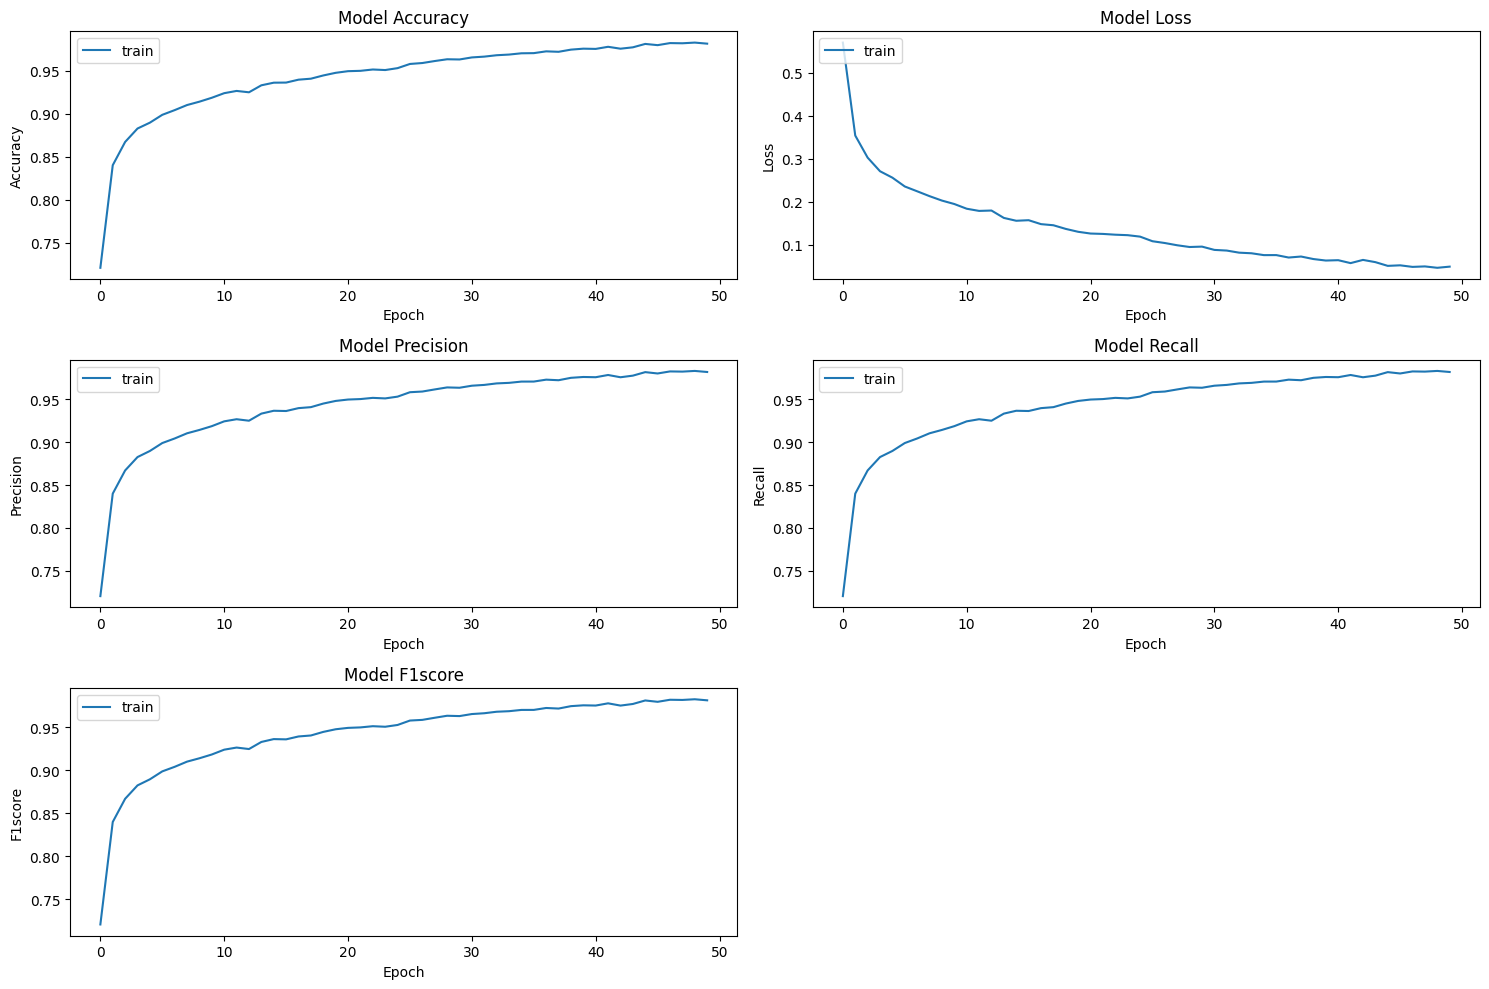

In [13]:
import matplotlib.pyplot as plt

def plotmodelhistory(history):
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))

    # Plot accuracy
    axs[0, 0].plot(history.history['accuracy'])
    axs[0, 0].set_title('Model Accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend(['train'], loc='upper left')

    # Plot loss
    axs[0, 1].plot(history.history['loss'])
    axs[0, 1].set_title('Model Loss')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend(['train'], loc='upper left')

    # Plot precision_m
    axs[1, 0].plot(history.history['precision_m'])
    axs[1, 0].set_title('Model Precision')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].legend(['train'], loc='upper left')

    # Plot recall_m
    axs[1, 1].plot(history.history['recall_m'])
    axs[1, 1].set_title('Model Recall')
    axs[1, 1].set_ylabel('Recall')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend(['train'], loc='upper left')

    # Plot f1score_m
    axs[2, 0].plot(history.history['f1_m'])
    axs[2, 0].set_title('Model F1score')
    axs[2, 0].set_ylabel('F1score')
    axs[2, 0].set_xlabel('Epoch')
    axs[2, 0].legend(['train'], loc='upper left')

    # Hide the last subplot
    axs[2, 1].axis('off')

    plt.tight_layout()
    plt.show()
# list all data in history
print(history.history.keys())
plotmodelhistory(history)

In [14]:
lost_test, accuracy_test, f1score_test, precision_test, recall_test = model.evaluate(X_test, Y_test, verbose=0)
print("Loss of test set is: ",lost_test)
print("Accuracy of test set is: ",accuracy_test)
print("F1score of test set is: ",f1score_test)
print("Precision of test set is: ",precision_test)
print("Recall of test set is: ",recall_test)

Loss of test set is:  0.5219670534133911
Accuracy of test set is:  0.8655497431755066
F1score of test set is:  0.8655347228050232
Precision of test set is:  0.8655347228050232
Recall of test set is:  0.8655347228050232


In [15]:
lost_test, accuracy_test, f1score_test, precision_test, recall_test = model.evaluate(X_train, Y_train, verbose=0)
print("Loss of train set is: ",lost_test)
print("Accuracy of train set is: ",accuracy_test)
print("F1score of train set is: ",f1score_test)
print("Precision of train set is: ",precision_test)
print("Recall of train set is: ",recall_test)

Loss of train set is:  0.030975455418229103
Accuracy of train set is:  0.9884193539619446
F1score of train set is:  0.9884209632873535
Precision of train set is:  0.9884209632873535
Recall of train set is:  0.9884209632873535


### Draw confusion matrix

In [16]:
label

array(['right thumb', 'left thumb'], dtype='<U11')

In [17]:
labels = list(label)
labels

['right thumb', 'left thumb']

2321/2321 [==============================] - 13s 6ms/step


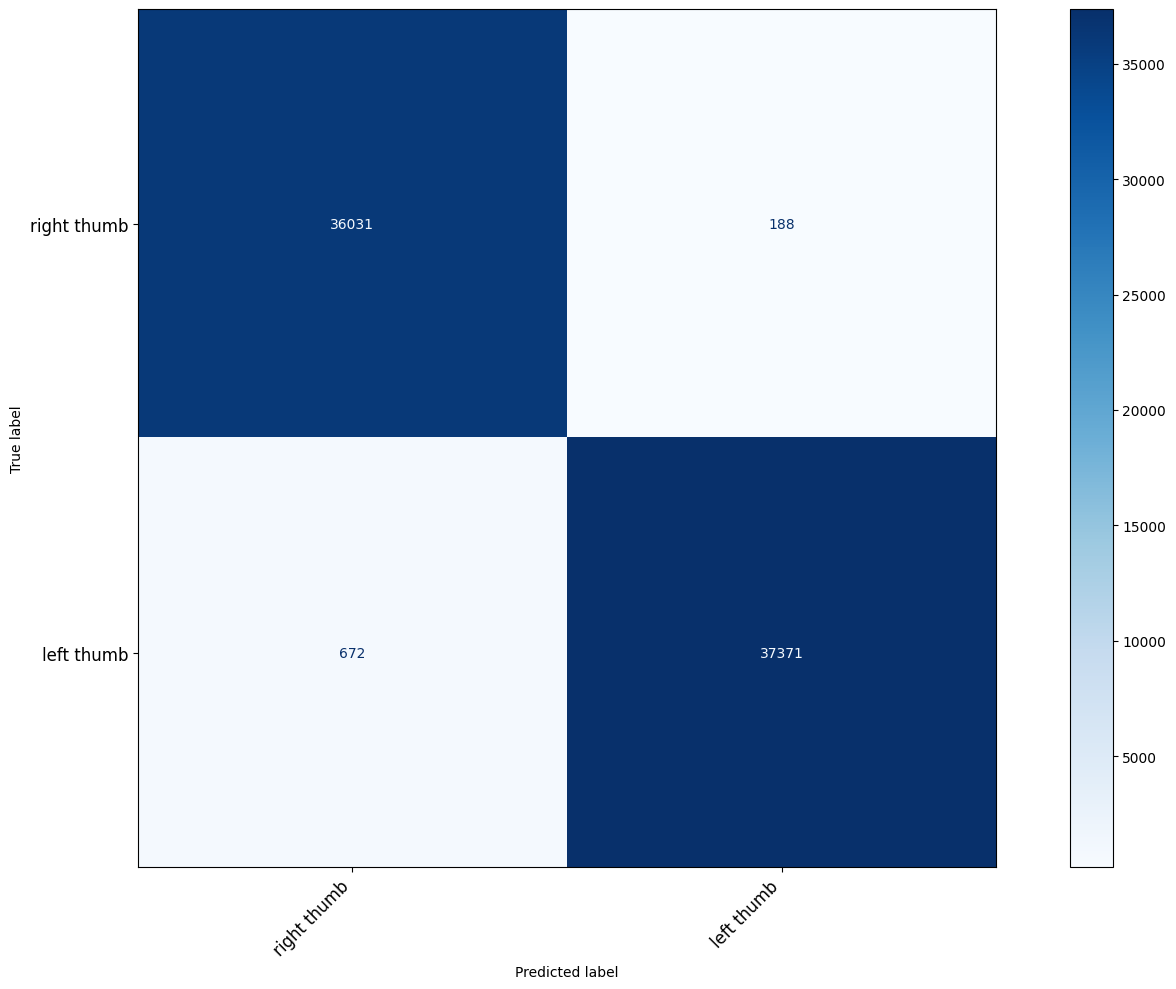

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_train, axis=1)

labels = list(label)
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 10))  # resize aspect ratio

# Draw confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Downsize font of xticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and downsize x-axis labels
plt.yticks(fontsize=12)  # Downsize y-axis labels

# Adjust the font size of the numbers in the cells
for text in disp.ax_.texts:
    text.set_fontsize(10)

# Use tight_layout to optimize layout
plt.tight_layout()

plt.show()


666/666 [==============================] - 3s 5ms/step


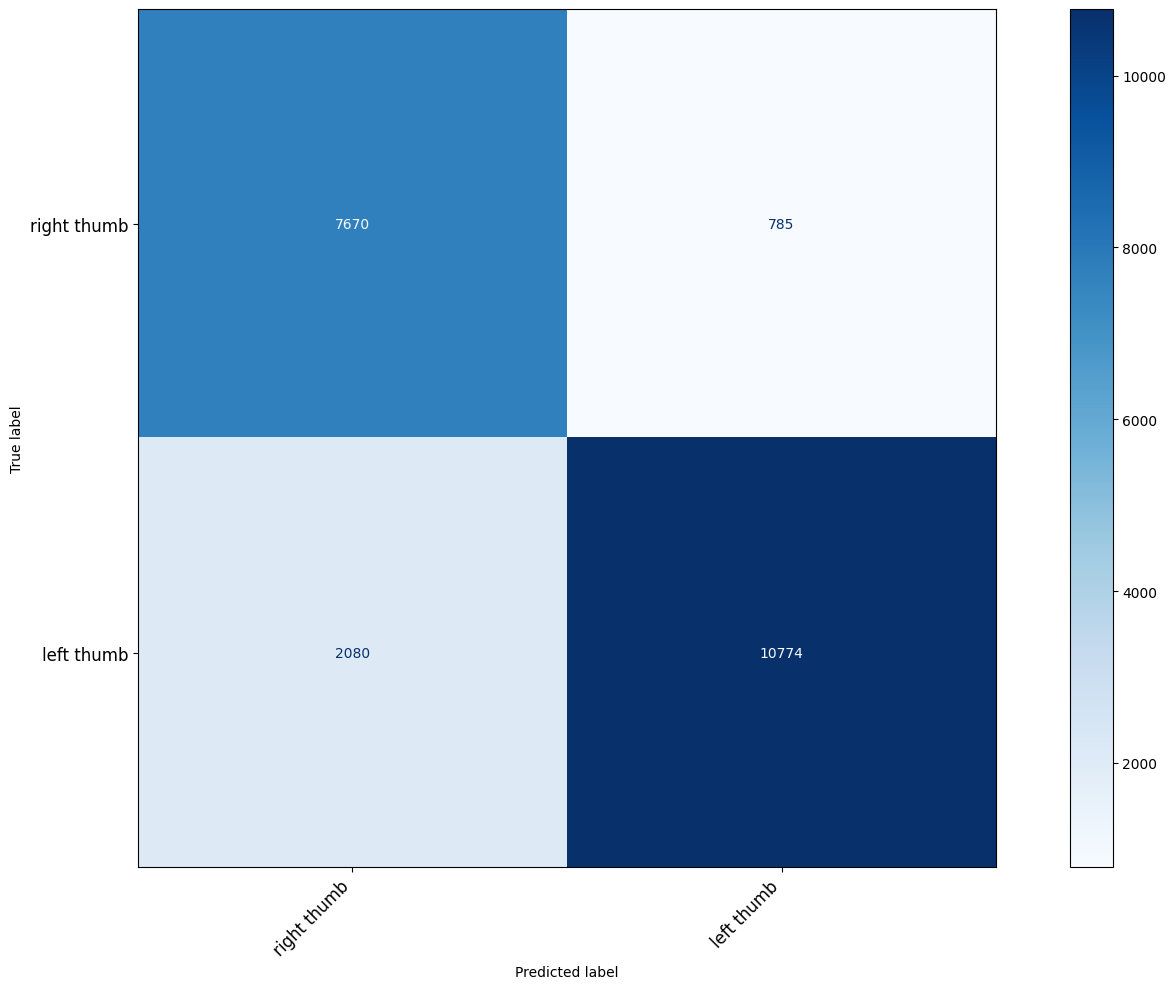

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

labels = list(label)
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(15, 10))  # resize aspect ratio

# Draw confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)

# Downsize font of xticks
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate and downsize x-axis labels
plt.yticks(fontsize=12)  # Downsize y-axis labels

# Adjust the font size of the numbers in the cells
for text in disp.ax_.texts:
    text.set_fontsize(10)

# Use tight_layout to optimize layout
plt.tight_layout()

plt.show()


In [20]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((74262, 32, 32, 1), (74262, 2), (21309, 32, 32, 1), (21309, 2))